In [32]:
import pandas as pd
import os
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
import lime
from sklearn.multiclass import OneVsRestClassifier
from yellowbrick.classifier import ROCAUC
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import nltk

## **ETL**

In [187]:
ready = glob(r'D:\Master BI e BDA\Lezioni\Project work\DWH\Incident.xlsx')[0]
ds = pd.read_excel(ready, engine = 'openpyxl', index_col=False,usecols=['description','statuscode','title','internalsolution',
'Priority','CaseInWarranty','Card_CaseType','caseorigincode_display','scm_isbilled','scm_isopeninwarranty'])
ds['description'] = ds['description'].replace('_x000D_\n','',regex=True)
ds['internalsolution'] = ds['internalsolution'].replace('_x000D_\n','',regex=True)
ds['title'] = ds['title'].replace('_x000D_\n','',regex=True)
ds['description'] = ds['description'].str.lower()
ds.head()

,description,statuscode,title,internalsolution,Priority,CaseInWarranty,Card_CaseType,caseorigincode_display,scm_isbilled,scm_isopeninwarranty
0,"hi,the kvara remains on a.network connection i...",Problem Solved,TAN/AA1/017425/DEMEESTERE MOEN/KVARA SYSTEM MO...,sent procedure to load CMOS on ATOM S500,02-HIGH,No,TECHNICAL ISSUE,Portal,False,False
1,"ciao, when the machine has to preform horizont...",Problem Solved,OVD/BOSCH/M100/ Drilling head too slow in Z axis,Fornito supporto tecnico via mail alla risoluz...,02-HIGH,No,TECHNICAL ISSUE,Portal,False,False
2,"buongiorno, abbiamo notato che nonostante a fi...",Problem Solved,Corsa Y Foratrice testa 1,Eseguendo una foratura in faccia anteriore in ...,02-HIGH,No,TECHNICAL ISSUE,Portal,False,False
3,all'accensione della macchina l'asse z della f...,Problem Solved,Asse Z2,14/4 gzdate info per verifiche,02-HIGH,No,TECHNICAL ISSUE,Portal,False,False
4,improvvisamente non riusciamo piu' a lanciare ...,Problem Solved,Problema avvio programmi Maestro Active,Mi collego in remoto e verifico errore nell'at...,02-HIGH,No,TECHNICAL ISSUE,Portal,False,False


In [188]:
ds.isnull().sum()

description                  8
statuscode                   0
title                       18
internalsolution          3616
Priority                   169
CaseInWarranty               0
Card_CaseType                0
caseorigincode_display       0
scm_isbilled                 0
scm_isopeninwarranty         0
dtype: int64

In [61]:
ds=ds.dropna(subset=['description','Priority'])

In [ ]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

def det(x):
    try:
        lang = detect(x)
    except:
        lang = 'Other'
    return lang

ds['Lingua'] =ds['description'].apply(det)
ds.head()

,description,statuscode,title,IncidentType,internalsolution,AverageRating,Priority,CaseInWarranty,Card_CaseType,caseorigincode_display,scm_isbilled,scm_isopeninwarranty,Lingua
0,"hi,the kvara remains on a.network connection i...",Problem Solved,TAN/AA1/017425/DEMEESTERE MOEN/KVARA SYSTEM MO...,TECHNICAL ISSUE,sent procedure to load CMOS on ATOM S500,0.0,02-HIGH,No,TECHNICAL ISSUE,Portal,False,False,en
1,"ciao, when the machine has to preform horizont...",Problem Solved,OVD/BOSCH/M100/ Drilling head too slow in Z axis,TECHNICAL ISSUE,Fornito supporto tecnico via mail alla risoluz...,0.0,02-HIGH,No,TECHNICAL ISSUE,Portal,False,False,en
2,"buongiorno, abbiamo notato che nonostante a fi...",Problem Solved,Corsa Y Foratrice testa 1,TECHNICAL ISSUE,Eseguendo una foratura in faccia anteriore in ...,0.0,02-HIGH,No,TECHNICAL ISSUE,Portal,False,False,it
3,all'accensione della macchina l'asse z della f...,Problem Solved,Asse Z2,TECHNICAL ISSUE,14/4 gzdate info per verifiche,0.0,02-HIGH,No,TECHNICAL ISSUE,Portal,False,False,it
4,improvvisamente non riusciamo piu' a lanciare ...,Problem Solved,Problema avvio programmi Maestro Active,TECHNICAL ISSUE,Mi collego in remoto e verifico errore nell'at...,0.0,02-HIGH,No,TECHNICAL ISSUE,Portal,False,False,it


In [ ]:
ds.to_csv('D:\Master BI e BDA\Lezioni\Project work\DWH\incident_wl.csv', index=False)

## **EDA**

In [19]:
ds = pd.read_csv(r"D:\Master BI e BDA\Lezioni\Project work\DWH\incident_wl.csv")
len(ds)

61192

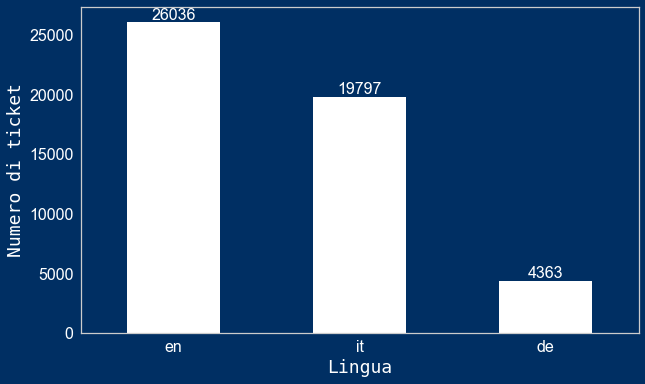

In [20]:
pyplot.figure(figsize=(10, 6),facecolor="#002f63")

bars = ds.Lingua.value_counts().sort_values(ascending=False).head(3).plot(kind = 'bar', rot=0, color="#ffffff")
bars.set_facecolor('#002f63')
pyplot.xlabel('Lingua',fontsize=18, fontname='monospace',color="#ffffff")
pyplot.ylabel('Numero di ticket',fontsize=18, fontname='monospace', color="#ffffff" )
pyplot.tick_params(axis='x',labelsize=16, colors='#ffffff')
pyplot.tick_params(axis='y',labelsize=16, colors='#ffffff')
pyplot.grid(False)
pyplot.bar_label(bars.containers[0],fontsize=16, color="#ffffff")

pyplot.show()

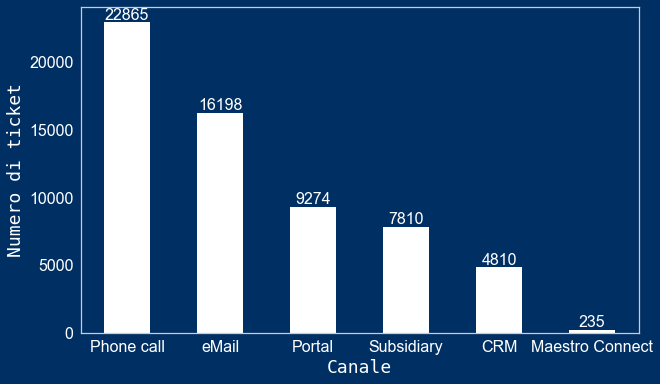

In [21]:
pyplot.figure(figsize=(10, 6),facecolor="#002f63")

bars = ds.caseorigincode_display.value_counts().sort_values(ascending=False).plot(kind = 'bar', rot=0,color="#ffffff")
bars.set_facecolor('#002f63')
pyplot.xlabel('Canale',fontsize=18, fontname='monospace',color="#ffffff")
pyplot.ylabel('Numero di ticket',fontsize=18, fontname='monospace', color="#ffffff" )
pyplot.tick_params(axis='x',labelsize=16, colors='#ffffff')
pyplot.tick_params(axis='y',labelsize=16, colors='#ffffff')
pyplot.grid(False)
pyplot.bar_label(bars.containers[0],fontsize=16, color="#ffffff")

pyplot.show()

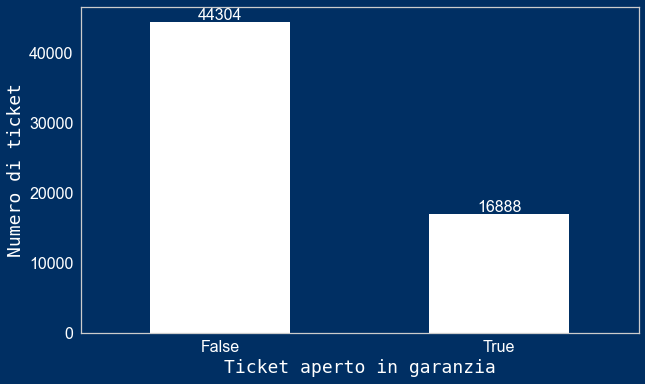

In [22]:
pyplot.figure(figsize=(10, 6),facecolor="#002f63")

bars = ds.scm_isopeninwarranty.value_counts().sort_values(ascending=False).plot(kind = 'bar', rot=0,color="#ffffff")
bars.set_facecolor('#002f63')
pyplot.xlabel('Ticket aperto in garanzia',fontsize=18, fontname='monospace',color="#ffffff")
pyplot.ylabel('Numero di ticket',fontsize=18, fontname='monospace', color="#ffffff" )
pyplot.tick_params(axis='x',labelsize=16, colors='#ffffff')
pyplot.tick_params(axis='y',labelsize=16, colors='#ffffff')
pyplot.grid(False)
pyplot.bar_label(bars.containers[0],fontsize=16, color="#ffffff")

pyplot.show()

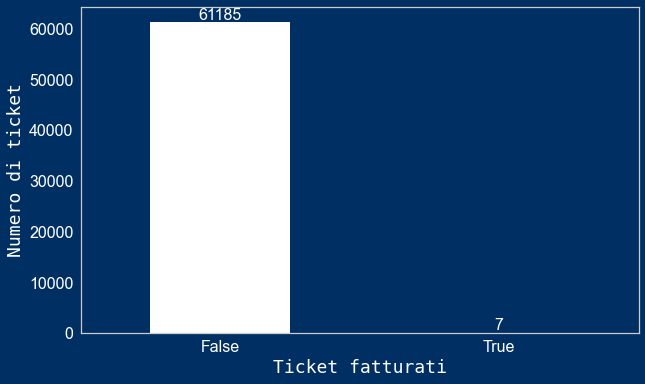

In [23]:
pyplot.figure(figsize=(10, 6),facecolor="#002f63")

bars = ds.scm_isbilled.value_counts().sort_values(ascending=False).plot(kind = 'bar', rot=0,color="#ffffff")
bars.set_facecolor('#002f63')
pyplot.xlabel('Ticket fatturati',fontsize=18, fontname='monospace',color="#ffffff")
pyplot.ylabel('Numero di ticket',fontsize=18, fontname='monospace', color="#ffffff" )
pyplot.tick_params(axis='x',labelsize=16, colors='#ffffff')
pyplot.tick_params(axis='y',labelsize=16, colors='#ffffff')
pyplot.grid(False)
pyplot.bar_label(bars.containers[0],fontsize=16, color="#ffffff")

pyplot.show()

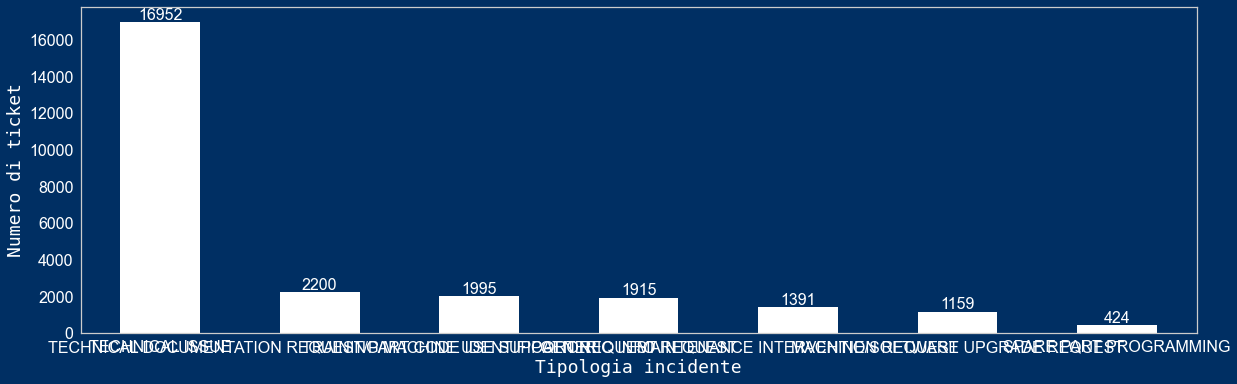

In [25]:
pyplot.figure(figsize=(20, 6),facecolor="#002f63")

ds=ds.loc[ds['Lingua'] == "en"]

bars = ds.Card_CaseType.value_counts().sort_values(ascending=False).plot(kind = 'bar', rot=0,color="#ffffff")
bars.set_facecolor('#002f63')
pyplot.xlabel('Tipologia incidente',fontsize=18, fontname='monospace',color="#ffffff")
pyplot.ylabel('Numero di ticket',fontsize=18, fontname='monospace', color="#ffffff" )
pyplot.tick_params(axis='x',labelsize=16, colors='#ffffff')
pyplot.tick_params(axis='y',labelsize=16, colors='#ffffff')
pyplot.grid(False)
pyplot.bar_label(bars.containers[0],fontsize=16, color="#ffffff")

pyplot.show()

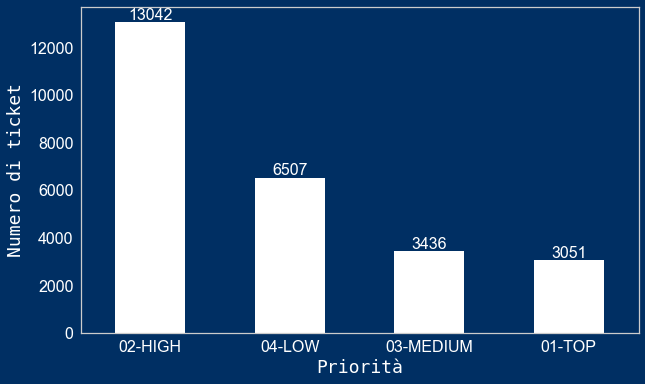

In [26]:
pyplot.figure(figsize=(10, 6),facecolor="#002f63")

ds=ds.loc[ds['Lingua'] == "en"]

bars = ds.Priority.value_counts().sort_values(ascending=False).plot(kind = 'bar', rot=0,color="#ffffff")
bars.set_facecolor('#002f63')
pyplot.xlabel('Priorità',fontsize=18, fontname='monospace',color="#ffffff")
pyplot.ylabel('Numero di ticket',fontsize=18, fontname='monospace', color="#ffffff" )
pyplot.tick_params(axis='x',labelsize=16, colors='#ffffff')
pyplot.tick_params(axis='y',labelsize=16, colors='#ffffff')
pyplot.grid(False)
pyplot.bar_label(bars.containers[0],fontsize=16, color="#ffffff")

pyplot.show()

## **LABEL ENCODING**

In [189]:
ds = pd.read_csv(r"D:\Master BI e BDA\Lezioni\Project work\DWH\incident_wl.csv")
from sklearn.preprocessing import LabelEncoder

encoder1 = LabelEncoder()
encoder2 = LabelEncoder()
encoder4 = LabelEncoder()
encoder1.fit(ds["Card_CaseType"])
encoder2.fit(ds["Priority"])
encoder4.fit(ds["scm_isopeninwarranty"])


ds['Card_CaseType'] = encoder1.transform(ds['Card_CaseType'])
inv_casetype = encoder1.inverse_transform(ds['Card_CaseType'])
ds['Priority'] = encoder2.transform(ds['Priority'])
inv_priority = encoder2.inverse_transform(ds['Priority'])
ds['scm_isopeninwarranty'] = encoder4.transform(ds['scm_isopeninwarranty'])
inv_warranty = encoder4.inverse_transform(ds['scm_isopeninwarranty'])

from collections import Counter
enc_casetype = ds['Card_CaseType'].to_numpy()
enc_priority = ds['Priority'].to_numpy()
enc_warranty = ds['scm_isopeninwarranty'].to_numpy()

print(Counter(inv_casetype) + Counter(enc_casetype))
print(Counter(inv_priority) + Counter(enc_priority))
print(Counter(inv_warranty) + Counter(enc_warranty))
ds.to_csv('D:\Master BI e BDA\Lezioni\Project work\DWH\incident_encoded_en.csv', index=False)

Counter({'TECHNICAL ISSUE': 40871, 5: 40871, 'TECHNICAL DOCUMENTATION REQUEST/PART CODE IDENTIFICATION': 3978, 4: 3978, 'GENERIC INFO REQUEST': 3930, 0: 3930, 'MAINTENANCE INTERVENTION REQUEST': 3588, 2: 3588, 'SPARE PART PROGRAMMING': 3432, 3: 3432, 'TRAINING/MACHINE USE SUPPORT REQUEST': 3116, 6: 3116, 'MACHINE/SOFTWARE UPGRADE REQUEST': 2277, 1: 2277})
Counter({'02-HIGH': 27836, 1: 27836, '04-LOW': 15798, 3: 15798, '01-TOP': 9786, 0: 9786, '03-MEDIUM': 7772, 2: 7772})
Counter({False: 88608, True: 33776})


## **LEMMATIZATION**

In [21]:
ds = pd.read_csv(r"D:\Master BI e BDA\Lezioni\Project work\DWH\incident_encoded_en.csv")

lemmatizer = WordNetLemmatizer() #porta la parola alla sua radice linguistica
ds=ds.loc[(ds['Lingua'].isin(["en","it"]))]
ds["description"] = ds["description"] + ds["title"].astype(str)
ds['description'] = ds['description'].str.lower()
ds['description'] = ds['description'].str.replace('[\W\s\d]',' ', regex=True) # W=punteggiatura, s=space, d=numeri
ds['description'] = ds['description'].str.split() #creiamo una lista con ogni parola della review. Le righe del df['Review'] adesso sono liste di parole  (una lista per ogni riga)
ds['description'] = ds['description'].apply(lambda x: [lemmatizer.lemmatize(sent) for sent in x])

ds["description"]= ds["description"].str.join(" ")
ds.head()

,description,statuscode,title,IncidentType,internalsolution,AverageRating,Priority,CaseInWarranty,Card_CaseType,caseorigincode_display,scm_isbilled,scm_isopeninwarranty,Lingua
0,hi the kvara remains on a network connection is compremised also i changed it to serial used cable from pilz and put in com of pc and put sw and to the left and changed the ini file from network to serial serial connection is working battery also replaced meanwhile most of the harddisk on the kvara cant be opened or formated all step in autosetup give error anything else i can do bootkey controller necassary to send to scm for repairing you can login at the customer i am not at customer for the moment so please call me if you need me id pw pai cnytcurrent situation serial cable connected pilz not changed ini file in kvara folder jmp and ontan aa demeestere moen kvara system monitor a,Problem Solved,TAN/AA1/017425/DEMEESTERE MOEN/KVARA SYSTEM MONITOR 8-> A,TECHNICAL ISSUE,sent procedure to load CMOS on ATOM S500,0.0,1,No,5,Portal,False,0,en
1,ciao when the machine ha to preform horizontal boring the machine move in the x direction before the head is in the down position this lead to the drill entering the panel diagonally this only happens when we preform the program on field lk in the attachment you find a pdf file with a better explanation of the issue with picture and video thanks in advace for the help oscarovd bosch m drilling head too slow in z axis,Problem Solved,OVD/BOSCH/M100/ Drilling head too slow in Z axis,TECHNICAL ISSUE,Fornito supporto tecnico via mail alla risoluzione del caso.Fornite indicazioni su regolazione freno pneumatico o corretta posizione della pausa G04F1 dopo il comando di discesa foratrice.Problema risolto.,0.0,1,No,5,Portal,False,0,en
2,buongiorno abbiamo notato che nonostante a fine corsa y la foratrice sia cm fuori dal piano di lavoro non riusciamo a lavorare in faccia anteriore se non dando un offset in y lasciando il fuori lavoro a mm come nelle altre lavorazioni siamo obbligati a dare un offset y di almeno mm volevo sapere se fosse una cosa normale o se ci sia un punto dove poter correggere eventualmente il finecorsa della foratrice corsa y foratrice testa,Problem Solved,Corsa Y Foratrice testa 1,TECHNICAL ISSUE,"Eseguendo una foratura in faccia anteriore in area AB il programma non viene caricato e compare il messaggio di ""incompatibilità geometrica o finecorsa assi.Per eseguire il programma è necessario inserire offset Y di posizionamento di almeno 30mm.Guardando il file ISO generato con il programma caricato con BY=30 si nota che la posizione Y a cui la testa scende per andare ad eseguire il foro é Y-1587.250 che è ben lontana dal finecorsa massimo dell'asse Y1 che è -1990.La testa si muove in manuale fino alla quota Y -1990 quindi non ci sono vincoli meccanici.",0.0,1,No,5,Portal,False,0,it
3,all accensione della macchina l asse z della foratrice scende dando errore inseguimento se lo blocco con un pezzo di legno e lancio la taratura poi tutto funziona come deve v del freno ok attendo assistenza grazie simoneasse z,Problem Solved,Asse Z2,TECHNICAL ISSUE,14/4 gzdate info per verifiche,0.0,1,No,5,Portal,False,0,it
4,improvvisamente non riusciamo piu a lanciare i programmi da maestro active quando cerchiamo di caricare un programma l interfaccia si blocca il problema e apparso durante un ciclo di prove sulla lunghezza delle punte foratrice abbiamo provato a recuperare anche un backup di maestro active problema avvio programmi maestro active,Problem Solved,Problema avvio programmi Maestro Active,TECHNICAL ISSUE,Mi collego in remoto e verifico errore nell'attrezzaggio modificato dal cliente.Ripristino attrezzaggio di collaudo e la macchina riprende il suo funzionamento corretto.Suggerisco a Michelangelo di verificare utensili nuovi creati in autonomia dal cliente,0.0,1,No,5,Portal,False,0,it


In [22]:
ds.to_csv('D:\Master BI e BDA\Lezioni\Project work\DWH\incident_lemm_encoded.csv', index=False)

## **TEXT MINING**

In [23]:
from gensim.models.phrases import Phrases
from nltk.corpus import stopwords
import ast
nltk.download('stopwords')

ds = pd.read_csv(r"D:\Master BI e BDA\Lezioni\Project work\DWH\incident_lemm_encoded.csv")
connectors = stopwords.words('italian')
#connectors.extend(['morning','please','thanks','thank','hello','ciao','hi','afternoon','evening'])
ds['description'] = ds['description'].str.split()
#ds['description'] =[ast.literal_eval(x) for x in ds['description'] ]
bigram = Phrases(ds['description'], min_count=2, threshold=0.1, common_terms=connectors)

bigrams = [bigram[item] for item in ds['description']]
ngrams = [bigram[item] for item in bigrams]
#print(bigrams[3:10])
#print(ngrams[3:10])

metadata = []
for row in ngrams:
    metadata.append(' '.join([item for item in row if item not in connectors]))
#metadata = [''.join(item) for item in ngrams]
ds.insert(loc=1, column='ngrams', value=metadata)
ds=ds.dropna(subset=['ngrams'])
ds.head()
ds["description"]= ds["description"].apply(' '.join)
ds.to_csv('D:\Master BI e BDA\Lezioni\Project work\DWH\incident_ngrams_encoded.csv', index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsalvatorelli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
ds.head()

,description,ngrams,statuscode,title,IncidentType,internalsolution,AverageRating,Priority,CaseInWarranty,Card_CaseType,caseorigincode_display,scm_isbilled,scm_isopeninwarranty,Lingua
0,buongiorno abbiamo notato che nonostante a fin...,buongiorno notato nonostante fine_corsa y fora...,Problem Solved,Corsa Y Foratrice testa 1,TECHNICAL ISSUE,Eseguendo una foratura in faccia anteriore in ...,0.0,1,No,5,Portal,False,0,it
1,all accensione della macchina l asse z della f...,accensione_della_macchina asse_z foratrice_sce...,Problem Solved,Asse Z2,TECHNICAL ISSUE,14/4 gzdate info per verifiche,0.0,1,No,5,Portal,False,0,it
2,improvvisamente non riusciamo piu a lanciare i...,improvvisamente riusciamo_piu lanciare_i_progr...,Problem Solved,Problema avvio programmi Maestro Active,TECHNICAL ISSUE,Mi collego in remoto e verifico errore nell'at...,0.0,1,No,5,Portal,False,0,it
3,ogni volta che faccio controllo progetto dà er...,ogni_volta controllo progetto dà_errore config...,Problem Solved,Maestro errore,TECHNICAL ISSUE,aggiornato alla versione 1.0.6.1080 di MA e 1....,0.0,1,No,5,Portal,False,0,it
4,ciao bisogno di fare un clone actual al disco ...,ciao_bisogno fare clone actual disco pc adesso...,Problem Solved,Clone di HD,TECHNICAL ISSUE,inviata procedura clone rev4 e indicazioni chi...,0.0,1,No,5,Portal,False,0,it


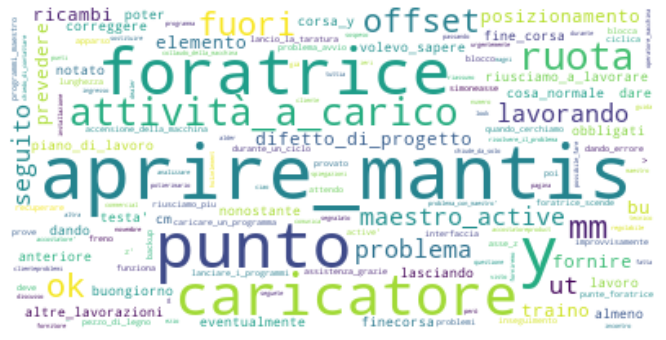

In [6]:
text = ds['ngrams'].values 
plt.figure(figsize=(20, 6))
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(text))
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## **VECTORIZATION & TEXT AUGMENTATION**

In [7]:
ds = pd.read_csv(r"D:\Master BI e BDA\Lezioni\Project work\DWH\incident_ngrams_encoded_en.csv")
ds=ds.dropna(subset=['ngrams'])
X = ds['ngrams']
y = ds[['Card_CaseType','Priority']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y,random_state=101)

In [8]:
import nlpaug
import nlpaug.augmenter.word as naw
import nltk
nltk.download('averaged_perceptron_tagger')

ds_aug = pd.DataFrame(y_train, columns =['Card_CaseType','Priority'])
ds_aug = pd.concat([ds_aug, ds_aug], axis=0)
print(len(ds_aug))

aug = naw.SynonymAug(aug_src='wordnet', name='Synonym_Aug', lang='eng', verbose=0)
x_train = x_train.to_list()
train_sentence_aug = aug.augment(x_train,3)
x_train = x_train + train_sentence_aug

ds_aug.insert(loc=1, column='x_train', value=x_train)
x_train = ds_aug['x_train']
y_train = ds_aug[['Card_CaseType','Priority']]

print(len(x_train))
print(len(y_train))
ds_aug.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dsalvatorelli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


29694
29694
29694


,Card_CaseType,x_train,Priority
13975,5,err_manca consenso_movimento spintoreerr manca...,1
14620,2,intervento manutenzionepreventivo intervento,3
7693,5,richiesta_in_garanziarichiesta garanzia,1
1735,4,richiesta_documentazionerichiesta documentazione,3
6834,3,programmaz_service shp_raa venditaprogrammato ...,0


In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000) #le 10mila parole più frequenti prese dal vocabolario, oltre va in crash
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
feature_names = vectorizer.get_feature_names()

from numpy import hstack
#X_prio = hstack((X, np.array(ds['scm_isopeninwarranty'])[:,None]))

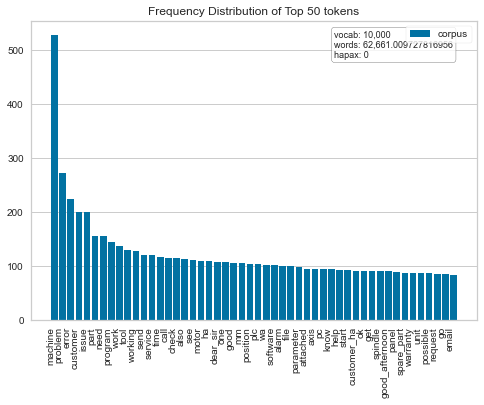

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [65]:
from yellowbrick.text import FreqDistVisualizer

visualizer = FreqDistVisualizer(features=feature_names, orient='v')
visualizer.fit(train_vectors)
visualizer.show()

## **OVERAMPLING**

Class=5, n=25430 (65.115%)
Class=1, n=1740 (4.455%)
Class=4, n=3298 (8.445%)
Class=6, n=2992 (7.661%)
Class=2, n=2086 (5.341%)
Class=3, n=636 (1.629%)
Class=0, n=2872 (7.354%)


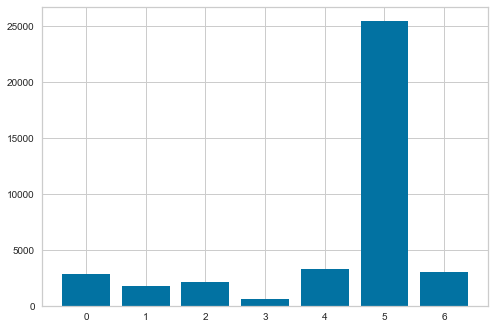

In [5]:
counter = Counter(y_train['Card_CaseType'])
for k,v in counter.items():
	per = v / len(y_train['Card_CaseType']) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=2, n=5154 (13.197%)
Class=1, n=19566 (50.100%)
Class=3, n=9758 (24.986%)
Class=0, n=4576 (11.717%)


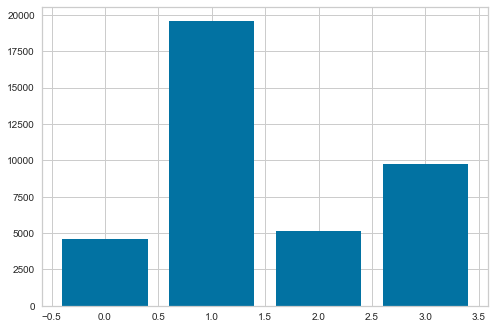

In [6]:
counter = Counter(y_train['Priority'])
for k,v in counter.items():
	per = v / len(y_train['Priority']) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [95]:
from imblearn.over_sampling import SMOTE
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
#sample_strategy = {5: 45430, 6: 7500, 0: 7500, 2: 7500, 4: 7500, 1:7500, 3:2000}
sample_strategy = {1: 20000, 2: 10000, 3: 15000, 0: 10000}
oversample = SMOTE(sampling_strategy=sample_strategy,random_state = 101, k_neighbors=5)
#x_trainct=x_train.astype(np.uint8)
#y_trainct=y_train.astype(np.uint8)

#train_vectors, y_trainct = oversample.fit_resample(train_vectors, y_train['Card_CaseType'])
train_vectors, y_trainpr = oversample.fit_resample(train_vectors, y_train['Priority'])

C:\Users\dsalvatorelli\AppData\Local\Programs\Python\Python38\lib\site-packages\imblearn\utils\_validation.py:318: UserWarning: After over-sampling, the number of samples (20000) in class 1 will be larger than the number of samples in the majority class (class #1 -> 19566)
  warnings.warn(


Class=5, n=45430 (53.491%)
Class=1, n=7500 (8.831%)
Class=4, n=7500 (8.831%)
Class=6, n=7500 (8.831%)
Class=2, n=7500 (8.831%)
Class=3, n=2000 (2.355%)
Class=0, n=7500 (8.831%)


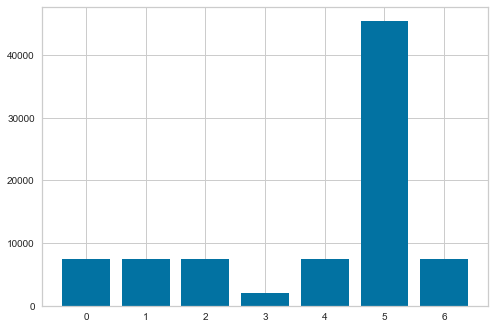

In [8]:
from collections import Counter
counter = Counter(y_trainct)
for k,v in counter.items():
	per = v / len(y_trainct) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

## **LINEAR CLASSIFICATION**

In [10]:
models = [MultinomialNB(alpha=.09)]
cvscores = []
cvrecall = []
cvf1 = []

for model in models:
    clfct = OneVsRestClassifier(model)
    clfct.fit(train_vectors, y_train['Card_CaseType'])
    predct = clfct.predict(test_vectors)
    f1 = sklearn.metrics.f1_score(y_test['Card_CaseType'], predct, average='weighted')
    scores = accuracy_score(y_test['Card_CaseType'], predct)
    recall = recall_score(y_test['Card_CaseType'], predct,average='macro')
    cvrecall.append(recall*100)
    cvscores.append(scores * 100)
    cvf1.append(f1 * 100)

print("accuracy_casetype: ",cvscores)
print("recall_casetype: ",cvrecall)
print("f1score_casetype: ",cvf1)
print(metrics.classification_report(y_test['Card_CaseType'], predct,zero_division=1))

accuracy_casetype:  [79.17171717171718]
recall_casetype:  [50.722552097091224]
f1score_casetype:  [75.4190983932351]
              precision    recall  f1-score   support

           0       0.66      0.21      0.32       400
           1       0.78      0.28      0.42       197
           2       0.74      0.45      0.56       307
           3       0.98      0.91      0.94       285
           4       0.82      0.65      0.73       363
           5       0.79      0.97      0.87      3214
           6       0.50      0.07      0.12       184

    accuracy                           0.79      4950
   macro avg       0.75      0.51      0.57      4950
weighted avg       0.78      0.79      0.75      4950



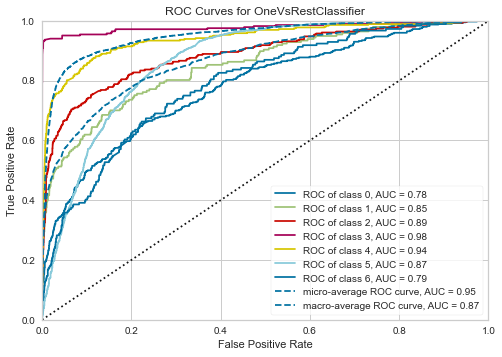

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [11]:
visualizer = ROCAUC(clfct, classes=["0", "1", "2","3","4","5","6","7"])

visualizer.fit(train_vectors, y_train['Card_CaseType'])        # Fit the training data to the visualizer
visualizer.score(test_vectors, y_test['Card_CaseType'])        # Evaluate the model on the test data
visualizer.show()

In [12]:
n = 3
probasct = clfct.predict_proba(test_vectors)
top_n_lables_idx = np.argsort(-probasct, axis=1)[:, :n]
top_n_probs = np.round(-np.sort(-probasct),3)[:, :n]
top_n_labels = [clfct.classes_[i] for i in top_n_lables_idx]
results = list(zip(top_n_labels, top_n_probs,y_test['Card_CaseType']))

result = pd.DataFrame(results, columns=['Prediction@3','Probabilities','Ground_truth'])
result=result.assign(Check=[a in b for a,b in zip(result['Ground_truth'],result['Prediction@3'])])
result['Check'] = result['Check'].astype(float)
result.head(20)

performance3 = float(100*(result['Check'].value_counts()[1])/len(result))

print("performance@3: ",performance3)
result['performance@3#1'] = result['Prediction@3'].str[0]
result['performance@3#2'] = result['Prediction@3'].str[1]
result['performance@3#3'] = result['Prediction@3'].str[2]
conditions=[result['performance@3#1'] == result['Ground_truth'],result['performance@3#2'] == result['Ground_truth'],result['performance@3#3'] == result['Ground_truth']] #for example
values=[1, 2/3, 1/3]
result['MRR']=np.select(conditions,values)
mrr3 = result["MRR"].mean()
print("mrr@3: ",mrr3*100)
result = result.drop(columns=['performance@3#1','performance@3#2','performance@3#3','Check'])
result.head(10)

performance@3:  93.61616161616162
mrr@3:  87.18518518518518


,Prediction@3,Probabilities,Ground_truth,MRR
0,"[5, 0, 6]","[0.886, 0.052, 0.029]",1,0.000000
1,"[5, 0, 4]","[0.805, 0.137, 0.041]",4,0.333333
2,"[5, 1, 0]","[0.754, 0.198, 0.022]",5,1.000000
3,"[5, 2, 0]","[0.829, 0.13, 0.018]",0,0.333333
4,"[5, 3, 4]","[0.988, 0.002, 0.002]",5,1.000000
5,"[5, 0, 6]","[0.906, 0.064, 0.014]",5,1.000000
6,"[5, 0, 2]","[0.945, 0.033, 0.007]",5,1.000000
7,"[5, 0, 2]","[0.821, 0.082, 0.06]",5,1.000000
8,"[5, 6, 1]","[0.933, 0.02, 0.019]",5,1.000000
9,"[5, 1, 3]","[0.536, 0.35, 0.033]",1,0.666667


In [13]:
models = [MultinomialNB(alpha=.4)]
cvscores = []
cvrecall = []
cvf1 = []

for model in models:
    clfpr = OneVsRestClassifier(model)
    clfpr.fit(train_vectors, y_train['Priority'])
    predpr = clfpr.predict(test_vectors)
    f1 = sklearn.metrics.f1_score(y_test['Priority'], predpr, average='weighted')
    scores = accuracy_score(y_test['Priority'], predpr)
    recall = recall_score(y_test['Priority'], predpr,average='macro')
    cvrecall.append(recall*100)
    cvscores.append(scores * 100)
    cvf1.append(f1 * 100)

print("accuracy priority: ",cvscores)
print("recall priority: ",cvrecall)
print("f1score_priority: ",cvf1)
print(metrics.classification_report(y_test['Priority'], predpr,zero_division=1))

accuracy priority:  [56.36363636363636]
recall priority:  [42.068902277840635]
f1score_priority:  [52.23036048075726]
              precision    recall  f1-score   support

           0       0.63      0.30      0.41      1054
           1       0.57      0.88      0.69      2254
           2       0.41      0.13      0.20       492
           3       0.54      0.36      0.43      1150

    accuracy                           0.56      4950
   macro avg       0.54      0.42      0.43      4950
weighted avg       0.56      0.56      0.52      4950



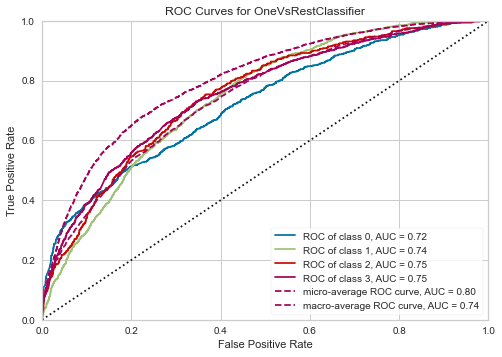

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [14]:
visualizer = ROCAUC(clfpr, classes=["0", "1", "2","3"])

visualizer.fit(train_vectors, y_train['Priority'])        # Fit the training data to the visualizer
visualizer.score(test_vectors, y_test['Priority'])        # Evaluate the model on the test data
visualizer.show()

In [15]:
n = 2
probaspr = clfpr.predict_proba(test_vectors)
top_n_lables_idx = np.argsort(-probaspr, axis=1)[:, :n]
top_n_probs = np.round(-np.sort(-probaspr),2)[:, :n]
top_n_labels = [clfpr.classes_[i] for i in top_n_lables_idx]
results = list(zip(top_n_labels, top_n_probs,y_test['Priority']))

result = pd.DataFrame(results, columns=['Prediction@2','Probabilities','Ground_truth'])
result=result.assign(Check=[a in b for a,b in zip(result['Ground_truth'],result['Prediction@2'])])
result['Check'] = result['Check'].astype(float)
result.head(20)

performance3 = float(100*(result['Check'].value_counts()[1])/len(result))

print("performance@2: ",performance3)
result['performance@2#1'] = result['Prediction@2'].str[0]
result['performance@2#2'] = result['Prediction@2'].str[1]
conditions=[result['performance@2#1'] == result['Ground_truth'],result['performance@2#2'] == result['Ground_truth']] #for example
values=[1, 1/2]
result['MRR']=np.select(conditions,values)
mrr3 = result["MRR"].mean()
print("mrr@3: ",mrr3*100)
result = result.drop(columns=['performance@2#1','performance@2#2','Check'])
result.head(10)

performance@2:  79.63636363636364
mrr@3:  68.0


,Prediction@2,Probabilities,Ground_truth,MRR
0,"[1, 0]","[0.66, 0.17]",1,1.0
1,"[0, 3]","[0.46, 0.37]",0,1.0
2,"[1, 3]","[0.59, 0.17]",1,1.0
3,"[2, 0]","[0.37, 0.32]",1,0.0
4,"[1, 0]","[0.74, 0.18]",0,0.5
5,"[1, 0]","[0.73, 0.16]",1,1.0
6,"[1, 3]","[0.67, 0.15]",1,1.0
7,"[1, 3]","[0.44, 0.42]",1,1.0
8,"[1, 0]","[0.62, 0.19]",1,1.0
9,"[3, 1]","[0.4, 0.3]",3,1.0


## **WORD2VEC & FASTTEXT**

In [16]:
ds= pd.read_csv(r'D:\Master BI e BDA\Lezioni\Project work\DWH\incident_ngrams_encoded_en.csv')
ds=ds.dropna(subset=['ngrams'])
train_sentences = ds['ngrams'].str.split()
train_sentences

0        [buongiorno, notato, nonostante, fine_corsa, y...
1        [accensione_della_macchina, asse_z, foratrice_...
2        [improvvisamente, riusciamo_piu, lanciare_i_pr...
3        [ogni_volta, controllo, progetto, dà_errore, c...
4        [ciao_bisogno, fare, clone, actual, disco, pc,...
                               ...                        
19792    [installando_la_macchina, showroom, errore, bu...
19793    [alleghiamo_modulo, compilato, richiesta_richi...
19794    [problemi, ciclica, accostatoreproduct, am, g,...
19795    [collaudo_della_macchina, questione, tecnico, ...
19796    [punti, sospeso, seguito, installazione, ciao,...
Name: ngrams, Length: 19797, dtype: object

In [17]:
from gensim.models import FastText

#min_n, max_n considera tutte le sottoparole di una parola che vanno da 3 a 6  perchè tiene conto dell'ortografia
%time ft_model = FastText(sg=1, hs=1, sentences=train_sentences, size=200, window=4, min_count=3, iter=10, min_n=3, max_n=6) #gensim 3

from gensim.models import Word2Vec

#sg: training algorithm. 1 for skipgram, 0 for cbow
#hs: optimization method. 1 for hierarchical softmax, 0 for negative sampling
#window = numero di parole da includere nel contesto
#min_count = quante volte deve esserci la parola per calcolare il contesto

#fare distribuzione di parole per definire min_count + provare skipgram

%time w2v_model = Word2Vec(sg=1, hs=1, sentences=train_sentences, size=200, window=4, min_count=3, iter=10) #gensim 3

Wall time: 2min 30s
Wall time: 32.1 s


In [18]:
len(w2v_model.wv.vocab)

19520

In [19]:
from gensim.models import KeyedVectors 
w2v_model.wv.save_word2vec_format(r'D:\Master BI e BDA\Lezioni\Project work\w2v_model.vec', binary=False)
ft_model.wv.save_word2vec_format(r'D:\Master BI e BDA\Lezioni\Project work\ft_model.vec', binary=False)

## **LSTM**

In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors 
embeddings = KeyedVectors.load_word2vec_format(r'D:\Master BI e BDA\Lezioni\Project work\ft_model_en.vec', binary=False)
max_length = 30

ds = pd.read_csv(r"D:\Master BI e BDA\Lezioni\Project work\DWH\incident_ngrams_encoded_en.csv")
ds=ds.dropna(subset=['ngrams'])
X = ds['ngrams']
y = ds[['Card_CaseType','Priority']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y,random_state=101)

t = Tokenizer()
t.fit_on_texts(x_train)
vocab_size = len(t.word_index) + 1
emb_size = embeddings.vector_size

encoded_docs_train = t.texts_to_sequences(x_train)
encoded_docs_test = t.texts_to_sequences(x_test)

padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

In [21]:
import tensorflow as tf
tf.random.set_seed(1)

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, emb_size))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if word in embeddings:
            weight_matrix[i] = embedding[word]
    return weight_matrix

In [32]:
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# get vectors in the right order
embedding_vectors = get_weight_matrix(embeddings, t.word_index)
print(embedding_vectors.shape)
e = Embedding(vocab_size, emb_size, weights=[embedding_vectors], input_length=max_length, trainable=False)

#params
opt = tf.keras.optimizers.Adam()
n_labels = 7
#n_labels = 4

# create the model
def baseline_model(optimizer=opt):
    model = Sequential()
    model.add(e)
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(n_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    return model

model = KerasClassifier(build_fn=baseline_model, epochs = 16, batch_size = 32, verbose=2)

%time model.fit(padded_docs_train, y_train['Card_CaseType'])

(31360, 200)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 200)           6272000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 50)            50200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 357       
Total params: 6,342,757
Trainable params: 70,757
Non-trainable params: 6,272,000
_________________________________________________________________
None
Epoch 1/16
464/464 - 11s - loss: 1.2563 - accuracy: 0.6683
Epoch 2/16
464/464 - 8s - loss: 1.0486 - accuracy: 0.6942
Epoch 3/16
464/464 - 8s - loss: 1.2370 - accuracy: 0.7008
Epoch 4/16
464/464 - 9s - loss: 0.8782 - acc

In [27]:
predct = model.predict(padded_docs_test)
accuracy = accuracy_score(y_test['Card_CaseType'], predct)
f1 = f1_score(y_test['Card_CaseType'], predct,average="weighted")
recall = recall_score(y_test['Card_CaseType'], predct,average='macro')
print('***RESULTS ON TEST SET***')
print("accuracy Card_CaseType", accuracy)
print("Recall Card_CaseType:", recall)
print("f1_score Card_CaseType", f1)
print(metrics.classification_report(y_test['Card_CaseType'], predct,zero_division=1))

C:\Users\dsalvatorelli\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


155/155 - 1s
***RESULTS ON TEST SET***
accuracy Card_CaseType 0.7527272727272727
Recall Card_CaseType: 0.5340602050986827
f1_score Card_CaseType 0.7329058194751157
              precision    recall  f1-score   support

           0       0.44      0.28      0.34       400
           1       0.50      0.35      0.41       197
           2       0.41      0.54      0.47       307
           3       0.92      0.93      0.93       285
           4       0.58      0.75      0.66       363
           5       0.84      0.88      0.86      3214
           6       0.50      0.01      0.01       184

    accuracy                           0.75      4950
   macro avg       0.60      0.53      0.52      4950
weighted avg       0.74      0.75      0.73      4950



In [29]:
predct = model.predict(padded_docs_test)
accuracy = accuracy_score(y_test['Priority'], predct)
f1 = f1_score(y_test['Priority'], predct,average="weighted")
recall = recall_score(y_test['Priority'], predct,average='macro')
print('***RESULTS ON TEST SET***')
print("accuracy priority", accuracy)
print("Recall priority:", recall)
print("f1_score priority", f1)
print(metrics.classification_report(y_test['Priority'], predct,zero_division=1))

C:\Users\dsalvatorelli\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


155/155 - 1s
***RESULTS ON TEST SET***
accuracy priority 0.5395959595959596
Recall priority: 0.4217713202682639
f1_score priority 0.5119847823830013
              precision    recall  f1-score   support

           0       0.54      0.28      0.37      1054
           1       0.59      0.78      0.67      2254
           2       0.41      0.16      0.23       492
           3       0.44      0.46      0.45      1150

    accuracy                           0.54      4950
   macro avg       0.49      0.42      0.43      4950
weighted avg       0.53      0.54      0.51      4950



In [26]:
n = 3
probasct = model.predict_proba(padded_docs_test)
top_n_lables_idx = np.argsort(-probasct, axis=1)[:, :n]
top_n_probs = np.round(-np.sort(-probasct),3)[:, :n]
top_n_labels = [model.classes_[i] for i in top_n_lables_idx]
results = list(zip(top_n_labels, top_n_probs,y_test['Card_CaseType']))

result = pd.DataFrame(results, columns=['Prediction@3','Probabilities','Ground_truth'])
result=result.assign(Check=[a in b for a,b in zip(result['Ground_truth'],result['Prediction@3'])])
result['Check'] = result['Check'].astype(float)
result.head(20)

performance3 = float(100*(result['Check'].value_counts()[1])/len(result))

print("performance@3: ",performance3)
result['performance@3#1'] = result['Prediction@3'].str[0]
result['performance@3#2'] = result['Prediction@3'].str[1]
result['performance@3#3'] = result['Prediction@3'].str[2]
conditions=[result['performance@3#1'] == result['Ground_truth'],result['performance@3#2'] == result['Ground_truth'],result['performance@3#3'] == result['Ground_truth']] #for example
values=[1, 2/3, 1/3]
result['MRR']=np.select(conditions,values)
mrr3 = result["MRR"].mean()
print("mrr@3: ",mrr3*100)
result = result.drop(columns=['performance@3#1','performance@3#2','performance@3#3','Check'])
result.head(10)

C:\Users\dsalvatorelli\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


155/155 - 1s
performance@3:  92.08080808080808
mrr@3:  84.60606060606061


,Prediction@3,Probabilities,Ground_truth,MRR
0,"[5, 0, 6]","[0.896, 0.046, 0.026]",1,0.000000
1,"[4, 0, 5]","[0.427, 0.296, 0.133]",4,1.000000
2,"[2, 5, 3]","[0.293, 0.249, 0.193]",5,0.666667
3,"[5, 2, 0]","[0.824, 0.079, 0.055]",0,0.333333
4,"[5, 0, 6]","[0.989, 0.005, 0.004]",5,1.000000
5,"[5, 0, 2]","[0.813, 0.077, 0.041]",5,1.000000
6,"[5, 0, 6]","[0.806, 0.061, 0.05]",5,1.000000
7,"[5, 2, 0]","[0.488, 0.409, 0.065]",5,1.000000
8,"[5, 0, 2]","[0.877, 0.045, 0.041]",5,1.000000
9,"[5, 2, 3]","[0.36, 0.281, 0.185]",1,0.000000


In [30]:
n = 2
probaspr = model.predict_proba(padded_docs_test)
top_n_lables_idx = np.argsort(-probaspr, axis=1)[:, :n]
top_n_probs = np.round(-np.sort(-probaspr),2)[:, :n]
top_n_labels = [model.classes_[i] for i in top_n_lables_idx]
results = list(zip(top_n_labels, top_n_probs,y_test['Priority']))

result = pd.DataFrame(results, columns=['Prediction@2','Probabilities','Ground_truth'])
result=result.assign(Check=[a in b for a,b in zip(result['Ground_truth'],result['Prediction@2'])])
result['Check'] = result['Check'].astype(float)
result.head(20)

performance3 = float(100*(result['Check'].value_counts()[1])/len(result))

print("performance@2: ",performance3)
result['performance@2#1'] = result['Prediction@2'].str[0]
result['performance@2#2'] = result['Prediction@2'].str[1]
conditions=[result['performance@2#1'] == result['Ground_truth'],result['performance@2#2'] == result['Ground_truth']] #for example
values=[1, 1/2]
result['MRR']=np.select(conditions,values)
mrr2 = result["MRR"].mean()
print("mrr@2: ",mrr2*100)
result = result.drop(columns=['performance@2#1','performance@2#2','Check'])
result.head(10)

C:\Users\dsalvatorelli\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


155/155 - 1s
performance@2:  76.74747474747475
mrr@2:  65.35353535353535


,Prediction@2,Probabilities,Ground_truth,MRR
0,"[1, 0]","[0.74, 0.13]",1,1.0
1,"[0, 3]","[0.4, 0.38]",0,1.0
2,"[1, 0]","[0.56, 0.22]",1,1.0
3,"[1, 3]","[0.47, 0.2]",1,1.0
4,"[1, 0]","[0.76, 0.22]",0,0.5
5,"[1, 0]","[0.86, 0.11]",1,1.0
6,"[1, 3]","[0.58, 0.34]",1,1.0
7,"[3, 0]","[0.69, 0.12]",1,0.0
8,"[1, 0]","[0.64, 0.21]",1,1.0
9,"[3, 0]","[0.91, 0.06]",3,1.0


In [91]:
from keras.models import load_model
filename = r'D:\Master BI e BDA\Lezioni\Project work\finalized_model_casetype_it.h5'
model.model.save(filename)
loaded_model = load_model(filename)
predct = loaded_model.predict(padded_docs_test)
predct=np.argmax(predct, axis=1)
accuracy = accuracy_score(y_test['Card_CaseType'], predct)
f1 = f1_score(y_test['Card_CaseType'], predct,average="weighted")
recall = recall_score(y_test['Card_CaseType'], predct,average='macro')
predct

AttributeError: 'Doc2Vec' object has no attribute 'model'

In [92]:
from keras.models import load_model
filename = r'D:\Master BI e BDA\Lezioni\Project work\finalized_model_priority_it.h5'
model.model.save(filename)
loaded_model = load_model(filename)
predct = loaded_model.predict(padded_docs_test)
predct=np.argmax(predct, axis=1)
accuracy = accuracy_score(y_test['Priority'], predct)
f1 = f1_score(y_test['Priority'], predct,average="weighted")
recall = recall_score(y_test['Priority'], predct,average='macro')
f1

AttributeError: 'Doc2Vec' object has no attribute 'model'

## **XAI**

In [41]:
dxai = pd.DataFrame(x_train,columns =['ngrams'])
dxai.insert(loc=1, column='Card_CaseType', value=y_train['Card_CaseType'])
dxai.insert(loc=2, column='Priority', value=y_train['Priority'])
dxai = dxai.reset_index(drop=True)
dxai.head()

,ngrams,Card_CaseType,Priority
0,err_manca consenso_movimento spintoreerr manca_consenso movimento_spintore,5,1
1,intervento manutenzionepreventivo intervento,2,3
2,richiesta_in_garanziarichiesta garanzia,5,1
3,richiesta_documentazionerichiesta documentazione,4,3
4,programmaz_service shp_raa venditaprogrammato ricambiovedi dettagli soluzione alleegatiprogrammaz ricambi,3,0


In [47]:
from lime.lime_text import LimeTextExplainer
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, clfct)
class_names = ['0','1','2','3','4','5','6']
explainer = LimeTextExplainer(class_names=class_names)

idx = 22
exp = explainer.explain_instance(dxai['ngrams'][idx], c.predict_proba, num_features=10, top_labels=3)
predicted_class = clfct.predict(test_vectors[idx]).reshape(1,-1)[0,0]
#predicted_class = [int(x) for x in str(predicted_class)]
true_class = dxai['Card_CaseType'][idx]
#true_class = [int(x) for x in str(true_class)]
print('Document id: %d' % idx, dxai['ngrams'][idx])
print('Predicted class =', predicted_class)
print('True class: %s' % true_class)
exp.show_in_notebook(text=True)

Document id: 22 buongiorno_con_la_presente chiedere cortesia urgente_intervento qui problemi sezionatrice_gabbiani riusciamo lavorarerimaniamo disposizione_per_eventuali chiarimenti_in_attesa riscontro_a_breve ribadiamo urgentemente_bisogno assistenza attendiamo chiamata immediatamente distinti_saluti diego puiattiurgente richiesta_di_intervento
Predicted class = 5
True class: 2


## **CONTENT-BASED RECOMMENDATION SYSTEM**

In [15]:
# Import gensim modules.
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import ast
from sklearn.metrics.pairwise import cosine_similarity

ds = pd.read_csv(r"D:\Master BI e BDA\Lezioni\Project work\DWH\incident_ngrams_encoded_en.csv")
ds=ds.dropna(subset=['ngrams','title','internalsolution'])

metadata = ds['ngrams']
metadata.to_list()
# Tagging documents. Each sentences(set of words) are mapped unique index.
# Tagged documents are input for doc2vec model. 
tagged_documents = []
for i, doc in enumerate(metadata):
    tagged = TaggedDocument(doc, [i])
    tagged_documents.append(tagged)

tagged_documents

[TaggedDocument(words='buongiorno notato nonostante fine_corsa y foratrice cm fuori piano_di_lavoro riusciamo_a_lavorare anteriore dando offset y lasciando fuori lavoro mm altre_lavorazioni obbligati dare offset y almeno mm volevo_sapere cosa_normale punto poter correggere eventualmente finecorsa foratrice corsa_y foratrice testa', tags=[0]),
 TaggedDocument(words='accensione_della_macchina asse_z foratrice_scende dando_errore inseguimento blocco pezzo_di_legno lancio_la_taratura poi funziona deve v freno ok attendo assistenza_grazie simoneasse z', tags=[1]),
 TaggedDocument(words='improvvisamente riusciamo_piu lanciare_i_programmi maestro_active quando_cerchiamo caricare_un_programma interfaccia blocca problema apparso durante_un_ciclo prove lunghezza punte_foratrice provato recuperare backup maestro_active problema_avvio programmi_maestro active', tags=[2]),
 TaggedDocument(words='ogni_volta controllo progetto dà_errore configurazione_macchina riesco_a_trovare errore teamviewer dispo

In [37]:
max_epochs = 10
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                workers=4)
  
model.build_vocab(tagged_documents)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_documents,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("D:\Master BI e BDA\Lezioni\Project work\d2v_it.model")
print("Model Saved")

iteration 0


<ipython-input-37-62871763cbfc>:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  epochs=model.iter)


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model Saved


In [3]:
pd.set_option('display.max_colwidth', None)
model= Doc2Vec.load("D:\Master BI e BDA\Lezioni\Project work\d2v_cbrs_it.model")

In [4]:
def recommend_system(incident):
    mapping = pd.Series(ds["ngrams"])
    mapping = mapping.to_frame().reset_index()
    mapping = pd.DataFrame.merge(ds[['description','ngrams','internalsolution']],
    mapping, on="ngrams")
    incident = incident.split()
    new_vector = model.infer_vector(incident)
    sims = model.docvecs.most_similar([new_vector])
    simsdf = pd.DataFrame(sims, columns=['index','cosine_similarity'])
    simsdf.head()
    top10sim = pd.DataFrame.merge(mapping,simsdf,on='index').sort_values(
        by='cosine_similarity',ascending = False)
    top10sim = top10sim.reset_index()
    top10sim = top10sim.drop(columns= ["index",'ngrams','level_0'])
    top10sim.head()  
    return top10sim

In [5]:
recommend_system("Attenzione, l'elettromandrino non sta funzionando")

,description,internalsolution,cosine_similarity
0,dear spare part department greeting i have a customer want to change the following item for olimpic k ah l g qty l b qty b qty the result on website shown to contact with you l g qty this code not working on spare part web site a qty for end cut unit upper motorso could you provide me an offer spare part,Dopo le spiegazioni date nel case CAS-31807-F1W8Q7 chiede al service un offerta per dei ricambi. Inoltrato la richiesta a spare parts department e sollecitato nuovamente che per tali richieste non deve contattare il service.,0.796811
1,ciao a tutti the customer is asking to upgrade the machine uniflex hp aa according to the actual state of the machine ux aa that they also have the ux aa ha the circuit breaker which defend the motor driving the drilling group the uniflex hp aa doe not have and the customer is claiming the burning of the motor on the uniflex due to the absence of the defence relevant page of the electrical diagram are attachedaccording to the opinion of the tecnician should be installed d pettine di colleg rv cb siemens it supplier code rv cb l b int aut m term p a rv ja siemens it supplier code rv ja l g int aut m term p a rv ga siemens it supplier code rv ga l f contatti au rv e siemens it supplier code rv e cable mm mtcable mm mtdin rack mplease check the possibility to modify the electrical scheme of the aa in a way to make it a much good a of the aa awaiting your kind answersergioaa circuit breaker for motor of drilling group,"Dear Sergeyit is obvious that over time improvements have been introduced on ux machines compared to uniflex machines.If the customer asks to electrically update the uniflex machine such as ux, it is necessary to open a quotation to evaluate feasibility and costs.So I ask you to keep in touch with the spare parts department who will take care of the request and will open a quotation to the technical office.",0.786236
2,good morning programsma suspend when load second panel maybe you have some solution because we check this problem in last weekadditional we have problem with position pusher value change position we found losen sensor and card http drive google com file d _ bqeeqesfvz a_lhht ofjfweg eq h view usp sharingthanksprogramsma suspend when load second panel,RICHIESTA GARANZIA,0.780614
3,panel mac software corrupted cant use machinepanel mac software corrupted cant use machine,xilog corrupted,0.779509
4,the customer would like to customise the above machine so that they can feed timber with only one cutting head running not like it is now where all cutting head must be running running infeed without all head started up,Contattare uff. ricambi,0.774991
5,software updatesoftware update,inviato mail per info aggiornamento software,0.771600
6,software updatesoftware update,inviato mail per info aggiornamento software,0.771600
7,software updatesoftware update,invio mail per aggiornamento software come da caso mantis,0.771600
8,software updatesoftware update,inviato mail per info aggiornamento software come da caso mantis,0.771600
9,software updatesoftware update,inviato mail per info aggiornamento software come da caso mantis,0.771600


## **GUI**

In [13]:
import tkinter as tk
from tkinter import Label, Entry, Button, StringVar, OptionMenu, Scrollbar, Listbox, ttk, Canvas
import pandas as pd
import numpy as np
import pickle
import PySimpleGUI as sg
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
from langdetect import detect
from langdetect import DetectorFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
DetectorFactory.seed = 0
pd.set_option('display.max_colwidth', None)

In [24]:
ds = pd.read_csv(r"D:\Master BI e BDA\Lezioni\Project work\DWH\incident_ngrams_encoded.csv", usecols=['ngrams','description','internalsolution','Lingua'])
ds=ds.loc[(ds['Lingua'].isin(["en","it"]))]
ds=ds.dropna(subset=['description','internalsolution'])
#model loading
cbrs_en_model = pickle.load(open(r'D:\Master BI e BDA\Lezioni\Project work\d2v_cbrs_en.model', 'rb'))
cbrs_it_model = pickle.load(open(r'D:\Master BI e BDA\Lezioni\Project work\d2v_cbrs_it.model', 'rb'))
casetype_en_model = load_model(r'D:\Master BI e BDA\Lezioni\Project work\finalized_model_casetype_en.h5')
casetype_it_model = load_model(r'D:\Master BI e BDA\Lezioni\Project work\finalized_model_casetype_it.h5')
priority_en_model = load_model(r'D:\Master BI e BDA\Lezioni\Project work\finalized_model_priority_en.h5')
priority_it_model = load_model(r'D:\Master BI e BDA\Lezioni\Project work\finalized_model_priority_it.h5')

description = ds['description']
description.to_list()
t = Tokenizer()
t.fit_on_texts(description)

root = tk.Tk()
root.title('SCM Recommendation system')
root.geometry("1024x768")
root.configure(bg='blue')
root.columnconfigure(0, minsize=30)
root.state("zoomed")

#recommendation function
tagged_documents = []
for i, doc in enumerate(description):
    tagged = TaggedDocument(doc, [i])
    tagged_documents.append(tagged)

def recommend_system(token):
    mapping = pd.Series(ds["ngrams"])
    mapping = mapping.to_frame().reset_index()
    mapping = pd.DataFrame.merge(ds[['description','ngrams','internalsolution']],mapping,on="ngrams")
    lang = detect(token)
    sims = []

    if lang == "en":
        token = token.split()
        new_vector = cbrs_en_model.infer_vector(token)
        sims = cbrs_en_model.docvecs.most_similar([new_vector])

    elif lang == "it":
        token = token.split()
        new_vector = cbrs_it_model.infer_vector(token)
        sims = cbrs_it_model.docvecs.most_similar([new_vector])

    simsdf = pd.DataFrame(sims, columns=['index','cosine_similarity'])
    top10sim = pd.DataFrame.merge(mapping,simsdf,on='index').sort_values(by='cosine_similarity',ascending = False)
    top10sim = top10sim.reset_index()
    top10sim = top10sim.drop(columns= ["index",'level_0','ngrams','cosine_similarity'])
    top10sim_desc = top10sim['description'].head(10)
    top10sim_sol = top10sim['internalsolution'].head(10)
    print(top10sim_desc)
    print(top10sim_sol)

    return top10sim_desc, top10sim_sol

def classification_system(token):
    lang = detect(token)
    token_tok = t.texts_to_sequences(token)
    token_tok = pad_sequences(token_tok, maxlen=30, padding='post')
    top_3_casetype = []
    top_2_priority = []

    if lang == "en":
        probasct = casetype_en_model.predict_proba(token_tok)
        top_3_casetype = np.argsort(-probasct, axis=1)[:, :3]
        probasct = probasct[0]*100
        probasct = [ '%.1f' % elem for elem in probasct]
        probaspr = priority_en_model.predict_proba(token_tok)
        top_2_priority = np.argsort(-probaspr, axis=1)[:, :2]
        probaspr = probaspr[0]*100
        probaspr = [ '%.1f' % elem for elem in probaspr]

    elif lang == "it":
        probasct = casetype_it_model.predict_proba(token_tok)
        top_3_casetype = np.argsort(-probasct, axis=1)[:, :3]
        probasct = probasct[0]*100
        probasct = [ '%.1f' % elem for elem in probasct]
        probaspr = priority_it_model.predict_proba(token_tok)
        top_2_priority = np.argsort(-probaspr, axis=1)[:, :2]
        probaspr = probaspr[0]*100
        probaspr = [ '%.1f' % elem for elem in probaspr]
    
    inc_type = list(top_3_casetype[0])
    triage = list(top_2_priority[0])

    for i, word in enumerate(inc_type):
        if word == 5:
            inc_type[i] = 'TECHNICAL ISSUE'
        elif word == 4:
            inc_type[i] = 'TECHNICAL DOCUMENTATION REQUEST/PART CODE IDENTIFICATION'
        elif word == 0:
            inc_type[i] = 'GENERIC INFO REQUEST'
        elif word == 2:
            inc_type[i] = 'MAINTENANCE INTERVENTION REQUEST'
        elif word == 3:
            inc_type[i] = 'SPARE PART PROGRAMMING'
        elif word == 6:
            inc_type[i] = 'TRAINING/MACHINE USE SUPPORT REQUEST'
        elif word == 1:
            inc_type[i] = 'MACHINE/SOFTWARE UPGRADE REQUEST'

    for i, word in enumerate(triage):
        if word == 1:
            triage[i] = 'HIGH'
        elif word == 3:
            triage[i] = 'LOW'
        elif word == 0:
            triage[i] = 'TOP'
        elif word == 2:
            triage[i] = 'MEDIUM'   

    ince = list(zip(inc_type,probasct))
    tri = list(zip(triage,probaspr))

    return ince,tri

clicked = StringVar()
e1 = Entry(root,width=50, font=('Consolas', 12))
e1.grid(row=6, column=0,sticky="w")

def show():
    global recommendation, inc, tria, print_inc, print_tria, token
    token = e1.get()
    recommend_result = recommend_system(token)
    classification_result = classification_system(token)
    recommendation = Label(root, text=recommend_result, font=('Consolas', 7),justify="left",border=0, fg='black',anchor="w", wraplength=900)
    inc = Label(root, text=classification_result[0], font=('Consolas', 12),justify="left",border=0, fg='black', anchor="w", wraplength=900)
    tria = Label(root, text=classification_result[1], font=('Consolas', 12),justify="left",border=0, fg='black', anchor="w",wraplength=900)
    print_inc = Label(root, text="Ti suggerisco queste 3 classi di incidente: ", font=('Consolas', 14),justify="left",border=0, fg='black', anchor="w",wraplength=900)
    print_tria = Label(root, text="Ti suggerisco queste 2 classi di triage: ", font=('Consolas', 14),justify="left",border=0, fg='black', anchor="w",wraplength=900)
    recommendation.grid(row = 30, column=2)
    print_inc.grid(row=1,column=2)
    inc.grid(row = 2,column=2)
    print_tria.grid(row=3, column=2)
    tria.grid(row=4,column=2)
    
def mydelete():
    recommendation.destroy()
    inc.destroy()
    tria.destroy()
    print_inc.destroy()
    print_tria.destroy()

myButton = Button(root, text="Recommend", font=('Consolas', 12), command=show,justify="left", anchor="w")
myButton.grid(row=2, column=0)
deletebutton = Button(root, text="Delete", font=('Consolas', 12), command=mydelete,justify="left", anchor="w")
deletebutton.grid(row=3, column=0)

root.mainloop()

0                                                            regarding the drilling retraction the machine pull out the drill completely only after the first drilling for multiple transition hole by dividing the hole into several depth the thing can be solved but it is very slow to return with feed speed before each catch we would need a solution to fully retract the drill before each catch and return quickly to the previous size even when reverting drilling strategy can be selected from a drop down menu but there is no corresponding option from mm deep hole approx we make piece a year which is already a lot of time loss with mm catch aa morbidelli m christeyns engineering kft
1                                                                                                                                                                                                                                                                                                                         

C:\Users\dsalvatorelli\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


C:\Users\dsalvatorelli\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
